Download the data...

- https://osf.io/fqm7x/download/

In [3]:
import pandas as pd
import numpy as np

s2_df = pd.read_excel('data/jayavulu/Supplementary_Table2.xlsx').sample(1000)
s2_df = s2_df.sort_values('log2FC').dropna(subset=['log2FC'])
s2_df = s2_df[s2_df['anno']=='tested_uncharacterized_CREs']
# s2_df['y']=np.where(s2_df['MPRA_validated_silencer']=='YES',1,0)
s2_df

,peakid,chr,start,end,anno,log2FC,P-val,adj.P-val,repressor_status,MPRA_validated_silencer
3251,peak3252,chr19,3736825,3737025,tested_uncharacterized_CREs,-4.789928,1.102449e-50,2.847469e-48,known_repressor,YES
6989,peak6990,chr8,33872176,33872376,tested_uncharacterized_CREs,-4.483495,3.848585e-50,9.277656e-48,no_known_repressor,YES
2107,peak2108,chr14,19643455,19643655,tested_uncharacterized_CREs,-4.332156,8.263693e-50,1.927840e-47,known_repressor,YES
4986,peak4987,chr3,195560875,195561075,tested_uncharacterized_CREs,-4.069221,3.464410e-49,7.158461e-47,known_repressor,YES
4340,peak4341,chr21,10580375,10580575,tested_uncharacterized_CREs,-4.007973,5.092181e-49,1.022963e-46,known_repressor,YES
...,...,...,...,...,...,...,...,...,...,...
1201,peak1202,chr11,13913576,13913776,tested_uncharacterized_CREs,1.510588,9.999913e-01,1.000000e+00,no_known_repressor,NO
249,peak250,chr1,57998096,57998296,tested_uncharacterized_CREs,1.525627,1.000000e+00,1.000000e+00,no_known_repressor,NO
3151,peak3152,chr18,48755796,48755996,tested_uncharacterized_CREs,1.532728,1.000000e+00,1.000000e+00,no_known_repressor,NO
7124,peak7125,chr8,101981456,101981656,tested_uncharacterized_CREs,1.900275,1.000000e+00,1.000000e+00,no_known_repressor,NO


<AxesSubplot:xlabel='log2FC', ylabel='Count'>

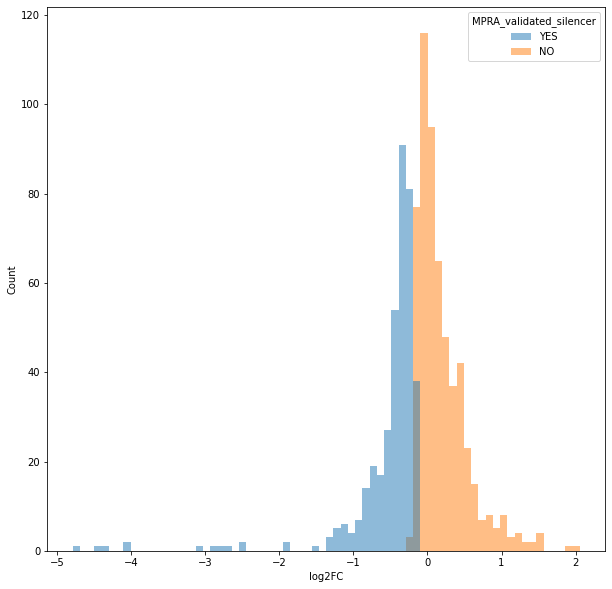

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=s2_df, x='log2FC', hue='MPRA_validated_silencer', stat='count', edgecolor=None)

DeepSilencer data:
    - will try regression instead...

<AxesSubplot:xlabel='log2FC', ylabel='Count'>

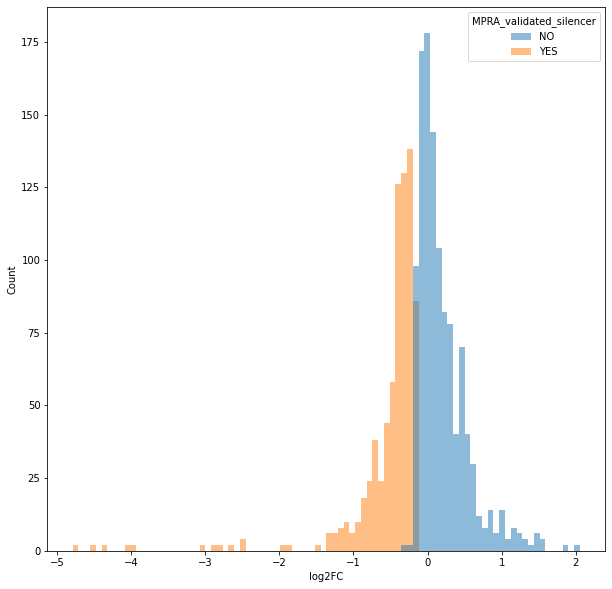

In [5]:
top = s2_df.nlargest(1000,'log2FC')
bottom=s2_df.nsmallest(1000,'log2FC')
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=pd.concat([top,bottom]), x='log2FC', hue='MPRA_validated_silencer', stat='count', edgecolor=None)

In [6]:
s2_df = pd.concat([top,bottom])

Will first try classification (can return to log2FC later).
- using `MPRA_validated_silencer` as label.

In [7]:
s2_df = s2_df.drop(set(s2_df.columns) - set(['chr', 'start','end', 'log2FC']),axis=1)
s2_df

,chr,start,end,log2FC
921,chr10,32837196,32837396,2.057311
7124,chr8,101981456,101981656,1.900275
3151,chr18,48755796,48755996,1.532728
249,chr1,57998096,57998296,1.525627
1201,chr11,13913576,13913776,1.510588
...,...,...,...,...
1201,chr11,13913576,13913776,1.510588
249,chr1,57998096,57998296,1.525627
3151,chr18,48755796,48755996,1.532728
7124,chr8,101981456,101981656,1.900275


In [8]:
from tqdm.notebook import tqdm_notebook
import pybedtools

Now, generating sequences from BED columns...

In [9]:
tqdm_notebook.pandas(desc='Generating sequences...')
s2_bt=pybedtools.BedTool.from_dataframe(s2_df)
s2_df['seq']=s2_df.progress_apply(lambda x : s2_bt.seq(loc=x,fasta='hg19.fa'), axis=1)
s2_df

Generating sequences...:   0%|          | 0/1892 [00:00<?, ?it/s]

,chr,start,end,log2FC,seq
921,chr10,32837196,32837396,2.057311,gctattttaaagagagcaggagtatgaactggaggggcagagtcag...
7124,chr8,101981456,101981656,1.900275,taaagtctgtgatctttctgataagtgcatagaagaaaacgctgac...
3151,chr18,48755796,48755996,1.532728,attccacttccatttgatgatgaaatactgctgtgtaggcccaact...
249,chr1,57998096,57998296,1.525627,ctggcatttttcacactatactctaatttggtttatctttcccatt...
1201,chr11,13913576,13913776,1.510588,taaggtctataagagagagcacctgcctagttttgcaaagtcacac...
...,...,...,...,...,...
1201,chr11,13913576,13913776,1.510588,taaggtctataagagagagcacctgcctagttttgcaaagtcacac...
249,chr1,57998096,57998296,1.525627,ctggcatttttcacactatactctaatttggtttatctttcccatt...
3151,chr18,48755796,48755996,1.532728,attccacttccatttgatgatgaaatactgctgtgtaggcccaact...
7124,chr8,101981456,101981656,1.900275,taaagtctgtgatctttctgataagtgcatagaagaaaacgctgac...


In [11]:
s2_df.to_csv('/Users/slevine-gottreich/github/DeepSilencer/data/s2.csv')

In [8]:
# from motif.motif_utils import seq2kmer
from tqdm._tqdm_notebook import tqdm_notebook

def seq2kmer(seq, k):
    """
    Convert original sequence to kmers
    
    Arguments:
    seq -- str, original sequence.
    k -- int, kmer of length k specified.
    
    Returns:
    kmers -- str, kmers separated by space

    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    kmers = " ".join(kmer)
    return kmers


<ipython-input-8-ab2859db7ccd>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


Now, generating 6-mers from these sequences...

In [9]:
s2_df['X']= s2_df.progress_apply(lambda row: seq2kmer(row['seq'],6),axis=1)
s2_df

Generating sequences...:   0%|          | 0/188 [00:00<?, ?it/s]

,chr,start,end,log2FC,seq,X
6993,chr8,36854056,36854256,1.587224,AATGAAAAATAAGCAAAACAGAGAAAAATACTTTCTCACTAATTAT...,AATGAA ATGAAA TGAAAA GAAAAA AAAAAT AAAATA AAAT...
3615,chr2,21865616,21865816,1.349605,TCCGCTCCTGATTGGATTTCATTACTATTCATAAGACCGTGTGGTG...,TCCGCT CCGCTC CGCTCC GCTCCT CTCCTG TCCTGA CCTG...
7364,chrX,22818536,22818736,1.153068,CATGTAGTAAATTACATCATtggttccaatgcttcacccttcctgg...,CATGTA ATGTAG TGTAGT GTAGTA TAGTAA AGTAAA GTAA...
5396,chr5,105657016,105657216,0.912185,ACACAGCAACACCCACATCCACACAGGCCTAGTCCTGAAGGAACGT...,ACACAG CACAGC ACAGCA CAGCAA AGCAAC GCAACA CAAC...
7332,chr9,129122435,129122635,0.848734,ctcttctgacatcttttttgacccataaattatttagatgtgtggt...,ctcttc tcttct cttctg ttctga tctgac ctgaca tgac...
...,...,...,...,...,...,...
7332,chr9,129122435,129122635,0.848734,ctcttctgacatcttttttgacccataaattatttagatgtgtggt...,ctcttc tcttct cttctg ttctga tctgac ctgaca tgac...
5396,chr5,105657016,105657216,0.912185,ACACAGCAACACCCACATCCACACAGGCCTAGTCCTGAAGGAACGT...,ACACAG CACAGC ACAGCA CAGCAA AGCAAC GCAACA CAAC...
7364,chrX,22818536,22818736,1.153068,CATGTAGTAAATTACATCATtggttccaatgcttcacccttcctgg...,CATGTA ATGTAG TGTAGT GTAGTA TAGTAA AGTAAA GTAA...
3615,chr2,21865616,21865816,1.349605,TCCGCTCCTGATTGGATTTCATTACTATTCATAAGACCGTGTGGTG...,TCCGCT CCGCTC CGCTCC GCTCCT CTCCTG TCCTGA CCTG...


Subsetting dev and train datasets...

In [10]:
from sklearn.model_selection import train_test_split
data = s2_df[['X','log2FC']].rename(columns={'X':'sequence','log2FC':'label'})
train, dev = train_test_split(data, test_size=0.2)
train.to_csv('data/jayavulu/train.tsv', sep = '\t', index=False)
dev.to_csv('data/jayavulu/dev.tsv', sep = '\t', index=False)

In [11]:
s2_df.seq.str.len()

6993    200
3615    200
7364    200
5396    200
7332    200
       ... 
7332    200
5396    200
7364    200
3615    200
6993    200
Name: seq, Length: 188, dtype: int64

Now, can run fine-tuning process...

***We collected the uncharacterized cis-regulatory elements (CREs) in K562 cells with MPRA provided by Jayavelu et al. Then we chose the top 2000 uncharacterized CREs sequences with the lowest MPRA activity as a positive set, and the bottom 2000 uncharacterized CREs with highest MPRA activity as a negative set.***

- ok for classification. but can directly perform regression (?).

### TEST DATA:

In [12]:
# encode_hg19_df = pd.read_csv('data/jayavulu/Candidate_silencers_and_uncharacterized_CREs_human_hg19_ENCODE_cell_types.txt',sep='\t')
# encode_hg19_df

In [13]:
# roadmap_hg19_df = pd.read_csv('data/jayavulu/Candidate_silencers_and_uncharacterized_CREs_human_hg19_roadmap_cell_types.txt',sep='\t')
# roadmap_hg19_df

In [14]:
# hg_19_merged_df = pd.concat([roadmap_hg19_df,encode_hg19_df])
# hg_19_merged_df=hg_19_merged_df.reset_index(drop=True).drop('peakid',axis=1)
# hg_19_merged_df

In [15]:
import argparse
import glob
import json
import logging
import os
import re
import shutil
import random
from multiprocessing import Pool
from typing import Dict, List, Tuple
from copy import deepcopy

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from src.transformers import (
    WEIGHTS_NAME,
    AdamW,
    AlbertConfig,
    AlbertForSequenceClassification,
    AlbertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    BertForLongSequenceClassification,
    BertForLongSequenceClassificationCat,
    BertTokenizer,
    DNATokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    FlaubertConfig,
    FlaubertForSequenceClassification,
    FlaubertTokenizer,
    RobertaConfig,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    XLMConfig,
    XLMForSequenceClassification,
    XLMRobertaConfig,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    XLMTokenizer,
    XLNetConfig,
    XLNetForSequenceClassification,
    XLNetTokenizer,
    get_linear_schedule_with_warmup,
)
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter


logger = logging.getLogger(__name__)

ALL_MODELS = sum(
    (
        tuple(conf.pretrained_config_archive_map.keys())
        for conf in (
            BertConfig,
            XLNetConfig,
            XLMConfig,
            RobertaConfig,
            DistilBertConfig,
            AlbertConfig,
            XLMRobertaConfig,
            FlaubertConfig,
        )
    ),
    (),
)

MODEL_CLASSES = {
    "dna": (BertConfig, BertForSequenceClassification, DNATokenizer),
    "dnalong": (BertConfig, BertForLongSequenceClassification, DNATokenizer),
    "dnalongcat": (BertConfig, BertForLongSequenceClassificationCat, DNATokenizer),
    "bert": (BertConfig, BertForSequenceClassification, BertTokenizer),
    "xlnet": (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    "xlm": (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    "roberta": (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer),
    "albert": (AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer),
    "xlmroberta": (XLMRobertaConfig, XLMRobertaForSequenceClassification, XLMRobertaTokenizer),
    "flaubert": (FlaubertConfig, FlaubertForSequenceClassification, FlaubertTokenizer),
}
                    
TOKEN_ID_GROUP = ["bert", "dnalong", "dnalongcat", "xlnet", "albert"] 

In [16]:
from loguru import logger

model = BertForSequenceClassification.from_pretrained(
    'dnaBERT_pretrained_models/6-new-12w-0_regression',

)

logger.info('finish loading model')


2021-06-24 10:20:20.797 | INFO     | __main__:<module>:8 - finish loading model


In [17]:
model.config.num_labels = 1
model.config.problem_type='regression'
model.classifier.out_features=1

In [18]:
model.forward()

ValueError: You have to specify either input_ids or inputs_embeds